# Importing the grayscale dataset containing and not containing faces

In [1]:
import numpy as np

In [2]:
faces = np.load('datasets/grayed_faces.npy').reshape(-1,48,48,1)
print(faces.shape)

(35887, 48, 48, 1)


In [3]:
notfaces = np.load('datasets/grayed_notfaces.npy').reshape(-1,48,48,1)
print(notfaces.shape)

(14596, 48, 48, 1)


In [7]:
in_X = np.vstack((list(faces),list(notfaces)))
print(in_X.shape)

(50483, 48, 48, 1)


# Generating labels

In [8]:
N1 = faces.shape[0]
y_faces = np.hstack([np.ones([N1, 1]), np.zeros([N1, 1])])

In [9]:
N2 = notfaces.shape[0]
y_notfaces = np.hstack([np.zeros([N2, 1]), np.ones([N2, 1])])

In [10]:
out_y = np.vstack([y_faces, y_notfaces])
print(out_y.shape)

(50483, 2)


# Shuffling the data and its labels the same way, then making the train, valid and test sets

In [11]:
N = N1 + N2
indices = list(range(N))
np.random.seed(124) # for making the procedure reproducable
np.random.shuffle(indices)

In [12]:
in_X = in_X[indices]
out_y = out_y[indices]

In [13]:
train = 0.7
val = 0.2
# test = 0.1
num_train = int(N*train)
num_val = int(N*val)
# num_test = int(N*test)
X_train = in_X[:num_train]
y_train = out_y[:num_train]
X_val = in_X[num_train:num_train+num_val]
y_val = out_y[num_train:num_train+num_val]
X_test = in_X[num_train+num_val:] # the remainer is for the test set
y_test = out_y[num_train+num_val:]

# Look at some of the training data

In [14]:
import matplotlib.pyplot as plt

Not a face:


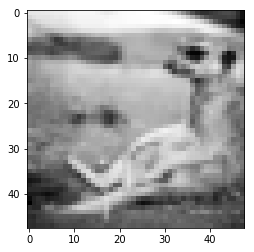

Face:


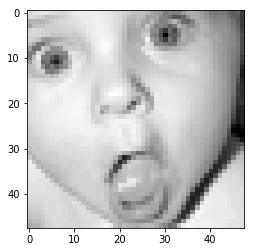

Face:


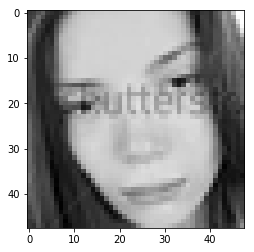

Face:


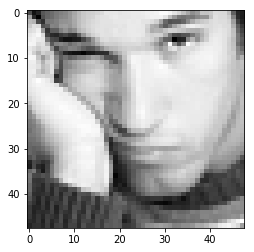

Face:


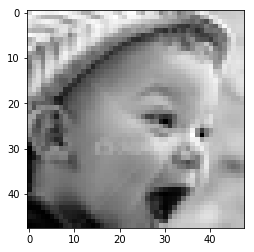

Face:


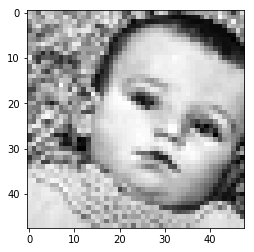

Face:


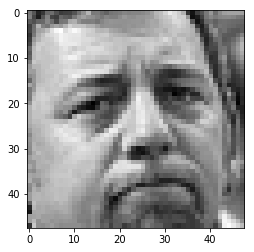

Not a face:


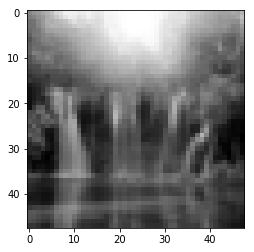

Face:


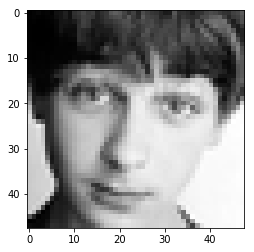

Not a face:


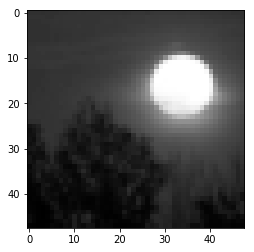

In [15]:
num_show = 10
for i in range(10):
    index = np.random.randint(num_train)
    
    if out_y[index,0]==1:
        print('Face:')
    else:
        print('Not a face:')
    
    plt.figure()
    plt.imshow(X_train[index].reshape([48,48]), cmap='gray', interpolation='nearest') # grayscale needs 
    plt.show()

# Hope the number of counterexamples will be enough, but it can be never enough, we should maybe get some little more

This cell was left blank intantionally

# Set up the network

In [16]:
import tensorflow as tf

### Some things

In [17]:
common_filters = 3
common_strides = [1,1,1,1]
common_padding = 'VALID'
layers = 19
fully_connected_neurons = 2048
H, W, C = in_X.shape[1:]
classes = out_y.shape[-1]

### Number of channels in layer outputs

In [19]:
channels = []
channels.append(C) # C is channels of input X
channel = 16
for i in range(layers):
    channel += i*2
    channels.append(channel)
print(channels)

[1, 16, 18, 22, 28, 36, 46, 58, 72, 88, 106, 126, 148, 172, 198, 226, 256, 288, 322, 358]


### Weights - default random values

In [20]:
Ws, bs = [0], [0] # just for the consistent numbering with layer numbers
print(0, Ws, bs)
for i in range(len(channels)-1):
    Ws.append(np.random.randn(common_filters, common_filters, channels[i], channels[i+1]).astype(np.float32)*1e-3)
    bs.append(np.zeros(channels[i+1]).astype(np.float32))
    print(i+1, np.array(Ws[i+1]).shape, np.array(bs[i+1]).shape)

0 [0] [0]
1 (3, 3, 1, 16) (16,)
2 (3, 3, 16, 18) (18,)
3 (3, 3, 18, 22) (22,)
4 (3, 3, 22, 28) (28,)
5 (3, 3, 28, 36) (36,)
6 (3, 3, 36, 46) (46,)
7 (3, 3, 46, 58) (58,)
8 (3, 3, 58, 72) (72,)
9 (3, 3, 72, 88) (88,)
10 (3, 3, 88, 106) (106,)
11 (3, 3, 106, 126) (126,)
12 (3, 3, 126, 148) (148,)
13 (3, 3, 148, 172) (172,)
14 (3, 3, 172, 198) (198,)
15 (3, 3, 198, 226) (226,)
16 (3, 3, 226, 256) (256,)
17 (3, 3, 256, 288) (288,)
18 (3, 3, 288, 322) (322,)
19 (3, 3, 322, 358) (358,)


### Layer's weights are trainable or not

In [21]:
trainables = [True]*len(Ws)
trainables[0] = 0 # not belonging anywhere
print(trainables)

[0, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


### Load trained weights, set them non-trainable

In [22]:
def load_weights():# loading already trained weights (we expect that if lower layer is not trained, then upper layer is neither)
    current_layer = 1 # training network with early layers, then adding additional layers to it, train it, add, train, ...
    path = 'weights/'
    for i in range(1, len(Ws)):
        try:
            W_pathname = path + 'W' + str(i) + '.npy'
            b_pathname = path + 'b' + str(i) + '.npy'
            cur_W = np.load(W_pathname)
            cur_b = np.load(b_pathname)
            Ws[i] = cur_W
            bs[i] = cur_b
            print('layer',i,'pretrained - loaded')
            trainables[i] = False
            current_layer += 1 # remember the last trained layer
        except:
            break # will not have upper layers...
    next_last_layer = current_layer
    return next_last_layer

# Describe Network

In [23]:
# but first, define the layers structure
def layer(prev_out, layer_number):
    W = tf.get_variable('W'+str(layer_number), initializer=Ws[layer_number], trainable=trainables[layer_number])
    b = tf.get_variable('b'+str(layer_number), initializer=bs[layer_number], trainable=trainables[layer_number])
    z = tf.nn.conv2d(prev_out,W,strides=common_strides, padding=common_padding) + b
    h = tf.nn.relu(z)
    return h

In [24]:
def nn(in_X, out_y, layers, fc_neurons, last_layer, wb_outlast):
    network = {'h1': layer(in_X, 1)}
    for i in range(1, layers):
        network['h'+str(i+1)] = layer(network['h'+str(i)], i+1)
        
    # fully connected layer at the end
    W_fc = tf.get_variable('W_fc', initializer=wb_outlast[0])
    b_fc = tf.get_variable('b_fc', initializer=wb_outlast[1])
    z_fc = tf.nn.conv2d(network['h'+str(last_layer)], W_fc, strides=common_strides, padding=common_padding) + b_fc
    h_fc = tf.nn.relu(z_fc)
    
    # output of network and loss
    W_out = tf.get_variable('W_out', initializer=wb_outlast[2])
    b_out = tf.get_variable('b_out', initializer=wb_outlast[3])
    z_out = tf.nn.conv2d(h_fc, W_out, strides=common_strides, padding=common_padding) + b_out
    y_out = tf.reshape(z_out, [-1, 2])
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=out_y, logits=y_out))
    
    return y_out, loss, network

'''
h1 = layer(X, 1)
h2 = layer(h1, 2)
h3 = layer(h2, 3)
h4 = layer(h3, 4)
h5 = layer(h4, 5)
h6 = layer(h5, 6)
h7 = layer(h6, 7)
h8 = layer(h7, 8)
h9 = layer(h8, 9)
h10 = layer(h9, 10)
h11 = layer(h10, 11)
h12 = layer(h11, 12)
h13 = layer(h12, 13)
h14 = layer(h13, 14)
h15 = layer(h14, 15)
h16 = layer(h15, 16)
h17 = layer(h16, 17)
h18 = layer(h17, 18)
h19 = layer(h18, 19)
h_fc
y_out
'''

'\nh1 = layer(X, 1)\nh2 = layer(h1, 2)\nh3 = layer(h2, 3)\nh4 = layer(h3, 4)\nh5 = layer(h4, 5)\nh6 = layer(h5, 6)\nh7 = layer(h6, 7)\nh8 = layer(h7, 8)\nh9 = layer(h8, 9)\nh10 = layer(h9, 10)\nh11 = layer(h10, 11)\nh12 = layer(h11, 12)\nh13 = layer(h12, 13)\nh14 = layer(h13, 14)\nh15 = layer(h14, 15)\nh16 = layer(h15, 16)\nh17 = layer(h16, 17)\nh18 = layer(h17, 18)\nh19 = layer(h18, 19)\nh_fc\ny_out\n'

# Define Network

In [25]:
'''print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(1)+":0"][0])), np.mean(Ws[1]))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(2)+":0"][0])), np.mean(Ws[2]))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_fc:0"][0])), np.mean(Ws[1]))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_out:0"][0])), np.mean(Ws[2]))'''

'print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(1)+":0"][0])), np.mean(Ws[1]))\nprint(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(2)+":0"][0])), np.mean(Ws[2]))\nprint(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_fc:0"][0])), np.mean(Ws[1]))\nprint(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_out:0"][0])), np.mean(Ws[2]))'

In [201]:
# but first, loading already trained weights
next_last_layer = load_weights()

current_last_layer = np.max([1, next_last_layer - 1])
print(trainables)

# additional modifications for educational purposes
#trainables[3] = True
print(trainables)
print('last layer is', current_last_layer)

layer 1 pretrained - loaded
layer 2 pretrained - loaded
layer 3 pretrained - loaded
[0, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[0, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
last layer is 3


In [202]:
tf.reset_default_graph()

# input, output
X = tf.placeholder(tf.float32, shape=[None, H, W, C])
y = tf.placeholder(tf.float32, [None, classes])

y_out, loss, net, trainer_step = [], [], [], []

last_layer = 4 #current_last_layer

path = 'weights/'
try:
    W_pathname = path + 'W_fc_'+str(last_layer)+'_last.npy'
    b_pathname = path + 'b_fc_'+str(last_layer)+'_last.npy'
    W_fc_rand_or_load = np.load(W_pathname)
    b_fc_rand_or_load = np.load(b_pathname)
    W_pathname = path + 'W_out_'+str(last_layer)+'_last.npy'
    b_pathname = path + 'b_out_'+str(last_layer)+'_last.npy'
    W_out_rand_or_load = np.load(W_pathname)
    b_out_rand_or_load = np.load(b_pathname)
    print('last and out layers imported')
except:
    print('no last and out layer weights were found')
    W_fc_rand_or_load = np.random.randn(H-last_layer*2, W-last_layer*2, channels[last_layer], fully_connected_neurons).astype(np.float32)
    b_fc_rand_or_load = np.random.randn(fully_connected_neurons).astype(np.float32)
    W_out_rand_or_load = np.random.randn(1, 1, fully_connected_neurons, classes).astype(np.float32)
    b_out_rand_or_load = np.random.randn(classes).astype(np.float32)
    print('made them random')

weight_outlast = [W_fc_rand_or_load, b_fc_rand_or_load, W_out_rand_or_load, b_out_rand_or_load]
def define_network(X, y, layers, fully_connected_neurons, last_layer, wb_outlast):# Cleaning
    
    # Creating the network
    y_out, loss, net = nn(X, y, layers, fully_connected_neurons, last_layer, wb_outlast)

    # trainer step
    learning_rate = 4e-4
    trainer_step = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
    
    return y_out, loss, net, trainer_step

y_out, loss, net, trainer_step = define_network(X, y, layers, fully_connected_neurons, last_layer, weight_outlast)

no last and out layer weights were found
made them random


In [203]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(1)+":0"][0])), np.mean(Ws[1]))
#print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(2)+":0"][0])), np.mean(Ws[2]))
#print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_fc:0"][0])), np.mean(W_fc_rand_or_load))
#print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_out:0"][0])), np.mean(W_out_rand_or_load))

In [204]:
last_layer

4

### check all the variables are good

In [205]:
tf.global_variables()

[<tf.Variable 'W1:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'W2:0' shape=(3, 3, 16, 18) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'W3:0' shape=(3, 3, 18, 22) dtype=float32_ref>,
 <tf.Variable 'b3:0' shape=(22,) dtype=float32_ref>,
 <tf.Variable 'W4:0' shape=(3, 3, 22, 28) dtype=float32_ref>,
 <tf.Variable 'b4:0' shape=(28,) dtype=float32_ref>,
 <tf.Variable 'W5:0' shape=(3, 3, 28, 36) dtype=float32_ref>,
 <tf.Variable 'b5:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'W6:0' shape=(3, 3, 36, 46) dtype=float32_ref>,
 <tf.Variable 'b6:0' shape=(46,) dtype=float32_ref>,
 <tf.Variable 'W7:0' shape=(3, 3, 46, 58) dtype=float32_ref>,
 <tf.Variable 'b7:0' shape=(58,) dtype=float32_ref>,
 <tf.Variable 'W8:0' shape=(3, 3, 58, 72) dtype=float32_ref>,
 <tf.Variable 'b8:0' shape=(72,) dtype=float32_ref>,
 <tf.Variable 'W9:0' shape=(3, 3, 72, 88) dtype=float32_ref>,
 <tf.Variable 'b9:0

# Training

In [206]:
#import tqdm
import matplotlib.pyplot as plt

In [207]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [208]:
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(1)+":0"][0])), np.mean(Ws[1]))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W"+str(2)+":0"][0])), np.mean(Ws[2]))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_fc:0"][0])), np.mean(W_fc_rand_or_load))
print(np.mean(sess.run([v for v in tf.global_variables() if v.name == "W_out:0"][0])), np.mean(W_out_rand_or_load))

-0.00126449 -0.00126449
-7.36349e-06 -7.36349e-06
0.000104803 0.000104803
0.00476352 0.00476352


In [217]:
y_pred = sess.run(y_out, {X: X_val[:1000], y: y_val[:1000]})
val_acc = np.mean(sess.run(tf.argmax(y_pred,1), {X: X_val[:1000], y: y_val[:1000]}) == sess.run(tf.argmax(y,1), {y: y_val[:1000]}))
print(val_acc)

0.705


In [218]:
# so we can early stop
best_val = np.inf

In [181]:
train_losses = []
val_losses = []
val_acces = []

In [221]:
epochs = 25
batch_size = 50
iterations = num_train//batch_size # the remainding just remains, it would be not so good to train on just a few samples when we want a batch size of 100 ...
validate_every = 150
patience = 5000 # iterations, note that you have to wait for evert validation... so patience is the max of (validate_every and patience)
count = 0
saver = tf.train.Saver()
early_stop = False
for i in range(epochs):
    print('starting epoch:', i)
    # shuffle before the epoch
    indices = np.random.permutation(num_train)
    X_train, y_train = X_train[indices], y_train[indices]
    
    # train for one epoch
    for j in range(iterations):
        X_batch, y_batch = X_train[batch_size*j:batch_size*(j+1)], y_train[batch_size*j:batch_size*(j+1)]
        # see the train and val losses before the iteration
        if j%validate_every == 0:
            train_loss = sess.run(loss, {X: X_batch, y: y_batch})
            val_indecies = np.random.choice(num_val, 1000)
            val_loss, y_pred = sess.run([loss, y_out], {X: X_val[val_indecies], y: y_val[val_indecies]}) # on the whole validation set
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_acc = sess.run(tf.reduce_mean(tf.cast(sess.run(tf.argmax(y_pred,1), {X: X_val[val_indecies], y:y_val[val_indecies]}) == sess.run(tf.argmax(y,1), {X: X_val[val_indecies], y:y_val[val_indecies]}), tf.float32)))
            val_acces.append(val_acc)
            
            # checking the validation if it is better than the better yet
            if val_loss < best_val:
                best_val = val_loss
                saver.save(sess, 'weights/early_stopping/best_val')
                print('new best model has been saved')
                # restart counter
                count = 0
            # if it was better, count gets to zero
            
            # early stop if our patience is over
            if count > patience:
                # loading back the model best validated
                print('early stopping, saving restored weights')
                saver.restore(sess, 'weights/early_stopping/best_val')
                early_stop = True
                
                # saving all the trainable layers up to the last layer...
                for k in range(1,last_layer+1):
                    if trainables[k]:
                        W_to_save = [v for v in tf.global_variables() if v.name == "W"+str(k)+":0"][0]
                        b_to_save = [v for v in tf.global_variables() if v.name == "b"+str(k)+":0"][0]
                        np.save('weights/W'+str(k), sess.run(W_to_save))
                        np.save('weights/b'+str(k), sess.run(b_to_save))
                # and also, saving the trained last layers for this last layery arrangement
                # so that we can continue with training with other parameters.....
                #FC
                W_to_save = [v for v in tf.global_variables() if v.name == "W_fc:0"][0]
                b_to_save = [v for v in tf.global_variables() if v.name == "b_fc:0"][0]
                np.save('weights/W_fc_'+str(last_layer)+'_last', sess.run(W_to_save))
                np.save('weights/b_fc_'+str(last_layer)+'_last', sess.run(b_to_save))
                #OUT
                W_to_save = [v for v in tf.global_variables() if v.name == "W_out:0"][0]
                b_to_save = [v for v in tf.global_variables() if v.name == "b_out:0"][0]
                np.save('weights/W_out_'+str(last_layer)+'_last', sess.run(W_to_save))
                np.save('weights/b_out_'+str(last_layer)+'_last', sess.run(b_to_save))
                # they are saved
                
                break
            # early stop end 
            
        # the actual training step
        sess.run(trainer_step, {X: X_train[:batch_size], y: y_train[:batch_size]})
        count += 1
    # one epoch ended
    
    if early_stop:
        break
        
saver.restore(sess, 'weights/early_stopping/best_val')
early_stop = True

# saving all the trainable layers up to the last layer...
for k in range(1,last_layer+1):
    if trainables[k]:
        W_to_save = [v for v in tf.global_variables() if v.name == "W"+str(k)+":0"][0]
        b_to_save = [v for v in tf.global_variables() if v.name == "b"+str(k)+":0"][0]
        np.save('weights/W'+str(k), sess.run(W_to_save))
        np.save('weights/b'+str(k), sess.run(b_to_save))
# and also, saving the trained last layers for this last layery arrangement
# so that we can continue with training with other parameters.....
#FC
W_to_save = [v for v in tf.global_variables() if v.name == "W_fc:0"][0]
b_to_save = [v for v in tf.global_variables() if v.name == "b_fc:0"][0]
np.save('weights/W_fc_'+str(last_layer)+'_last', sess.run(W_to_save))
np.save('weights/b_fc_'+str(last_layer)+'_last', sess.run(b_to_save))
#OUT
W_to_save = [v for v in tf.global_variables() if v.name == "W_out:0"][0]
b_to_save = [v for v in tf.global_variables() if v.name == "b_out:0"][0]
np.save('weights/W_out_'+str(last_layer)+'_last', sess.run(W_to_save))
np.save('weights/b_out_'+str(last_layer)+'_last', sess.run(b_to_save))
# they are saved

            

starting epoch: 0
new best model has been saved
new best model has been saved
new best model has been saved
new best model has been saved
starting epoch: 1
new best model has been saved
new best model has been saved
new best model has been saved
new best model has been saved
starting epoch: 2
new best model has been saved
new best model has been saved
new best model has been saved
starting epoch: 3
new best model has been saved
starting epoch: 4
new best model has been saved
new best model has been saved
starting epoch: 5
starting epoch: 6
starting epoch: 7
new best model has been saved
new best model has been saved
starting epoch: 8
new best model has been saved
starting epoch: 9
new best model has been saved
starting epoch: 10
new best model has been saved
starting epoch: 11
starting epoch: 12
new best model has been saved
new best model has been saved
starting epoch: 13
starting epoch: 14
starting epoch: 15
new best model has been saved
starting epoch: 16
starting epoch: 17
starting

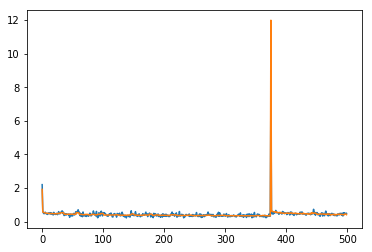

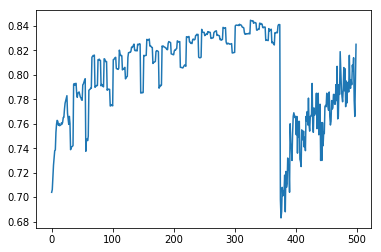

In [222]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
# accuracies on other figure
plt.figure()
plt.plot(val_acces)
plt.show()